# Particle Tracking

In this notebook we repeat the particle tracking of the sheared square ice experiments. Previously, (by analysing the first frame)[ReanalyseFirstFrames.ipynb] we found that using a correlation based tracking yielded a more robust algorithm, with less spurious particles and less particles lost. Here we will do the same, but for all frames. 

In [1]:
import os
import sys
import glob
sys.path.insert(0, './')

import icenumerics as ice
import correlation_locating as coloc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import trackpy as tp
import pims as pm
from pims import pipeline
from tqdm import tqdm_notebook
import support as sp

%matplotlib inline
idx = pd.IndexSlice

ureg = ice.ureg
@pipeline
def as_gray(frame):
    red = frame[:, :, 0]
    green = frame[:, :, 1]
    blue = frame[:, :, 2]
    return 0.2125 * red + 0.7154 * green + 0.0721 * blue

%load_ext autoreload
%autoreload 2

In [2]:
def strip_name(name,ext): 
    name = os.path.split(name)[-1]
    return name[:name.find(ext)]

In [3]:
mpl.rc('text', usetex=True)
mpl.rcParams['figure.dpi'] = 150

In [4]:
## Directory where the data is located
directory = "C:/Users/aortiza/Desktop/ShearedSquare/Theta45"

In [5]:
## Get a list of videos in that folder
theta = 45
filenames = [file for file in glob.glob(
    os.path.join(directory,('*.avi')))]
filenames = [f for f in filenames if not (f.find("O2")>0) and not (f.find("O1")>0)]

In [6]:
# The microscope magnification is:
pxsize = 0.59 # um /pixel
# Then 10um particles should have a radius of:
radius = 5/pxsize
radius

8.474576271186441

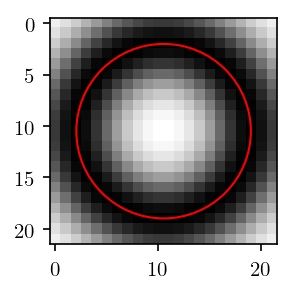

In [7]:
diameter = 2*radius
sim_part = coloc.simulated_particle(diameter,thick_ratio=0.5)
  
coloc.visualize_template(sim_part, diameter=diameter)

In [8]:
filenames[0]

'C:/Users/aortiza/Desktop/ShearedSquare/Theta45\\E5_M8_teta45_10um_2019_06_04_15_32_20.avi'

In [9]:
%%time
i = 0

@pipeline 
def convolve(image):
    return coloc.template_convolve(image,sim_part)

def locate_and_track(filename):
    try:
        video = pm.open(filename)
        location = tp.batch(convolve(as_gray(video[:])), 2*round(radius)+1, invert=False, characterize=False)
        location.to_csv(filename[:filename.find(".avi")]+"_location.dat", sep = "\t")
        tracking = tp.link(location, 8, memory = 5)
        tracking = tracking.set_index(["frame","particle"])
        tracking.to_csv(filename[:filename.find(".avi")]+"_tracking2.dat", sep="\t")
    except:
        return filename
    
failed =[locate_and_track(f) for f in filenames[:]]

Frame 9045: 146 trajectories present.
Wall time: 7h 47min 10s


In [10]:
failed

[None, None, None, None, None, None, None, None, None, None]

## Some Diagnostics

Below we check the results of the tracking. We also remove all particles with short trajectories (stubs).

In [2]:
import os
import sys
import glob
sys.path.insert(0, './')

import icenumerics as ice
import correlation_locating as coloc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import trackpy as tp
import pims as pm
from pims import pipeline
from tqdm import tqdm_notebook
import support as sp

%matplotlib inline
idx = pd.IndexSlice

ureg = ice.ureg
@pipeline
def as_gray(frame):
    red = frame[:, :, 0]
    green = frame[:, :, 1]
    blue = frame[:, :, 2]
    return 0.2125 * red + 0.7154 * green + 0.0721 * blue

%load_ext autoreload
%autoreload 2

In [3]:
mpl.rc('text', usetex=True)
mpl.rcParams['figure.dpi'] = 150

In [4]:
## Directory where the data is located
directory = "C:/Users/aortiza/Desktop/ShearedSquare/Theta45"

## Get a list of videos in that folder
theta = 45
filenames = [file for file in glob.glob(
    os.path.join(directory,('*.avi')))]
filenames = [f for f in filenames if not (f.find("O2")>0) and not (f.find("O1")>0)]

We first remove the trajectories which are very short. It's ok if some frames are missing, but not more than $90\%$

In [5]:
def remove_stubs(trj, percentage):
    
    trj_lengths = trj.groupby("particle").count().x
    return trj.loc[idx[:,trj_lengths[trj_lengths>(max(trj_lengths)*percentage)].index],:]

C:\Users\aortiza\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
C:\Users\aortiza\Anaconda3\lib\site-packages\pims\api.py:191: UserWarning: <class 'pims.pyav_reader.PyAVReaderTimed'> errored: 'NoneType' object has no attribute 'open'
  warn(message)
C:\Users\aortiza\Anaconda3\lib\site-packages\pims\api.py:191: UserWarning: <class 'pims.pyav_reader.PyAVReaderIndexed'> errored: 'NoneType' object has no attribute 'open'
  warn(message)


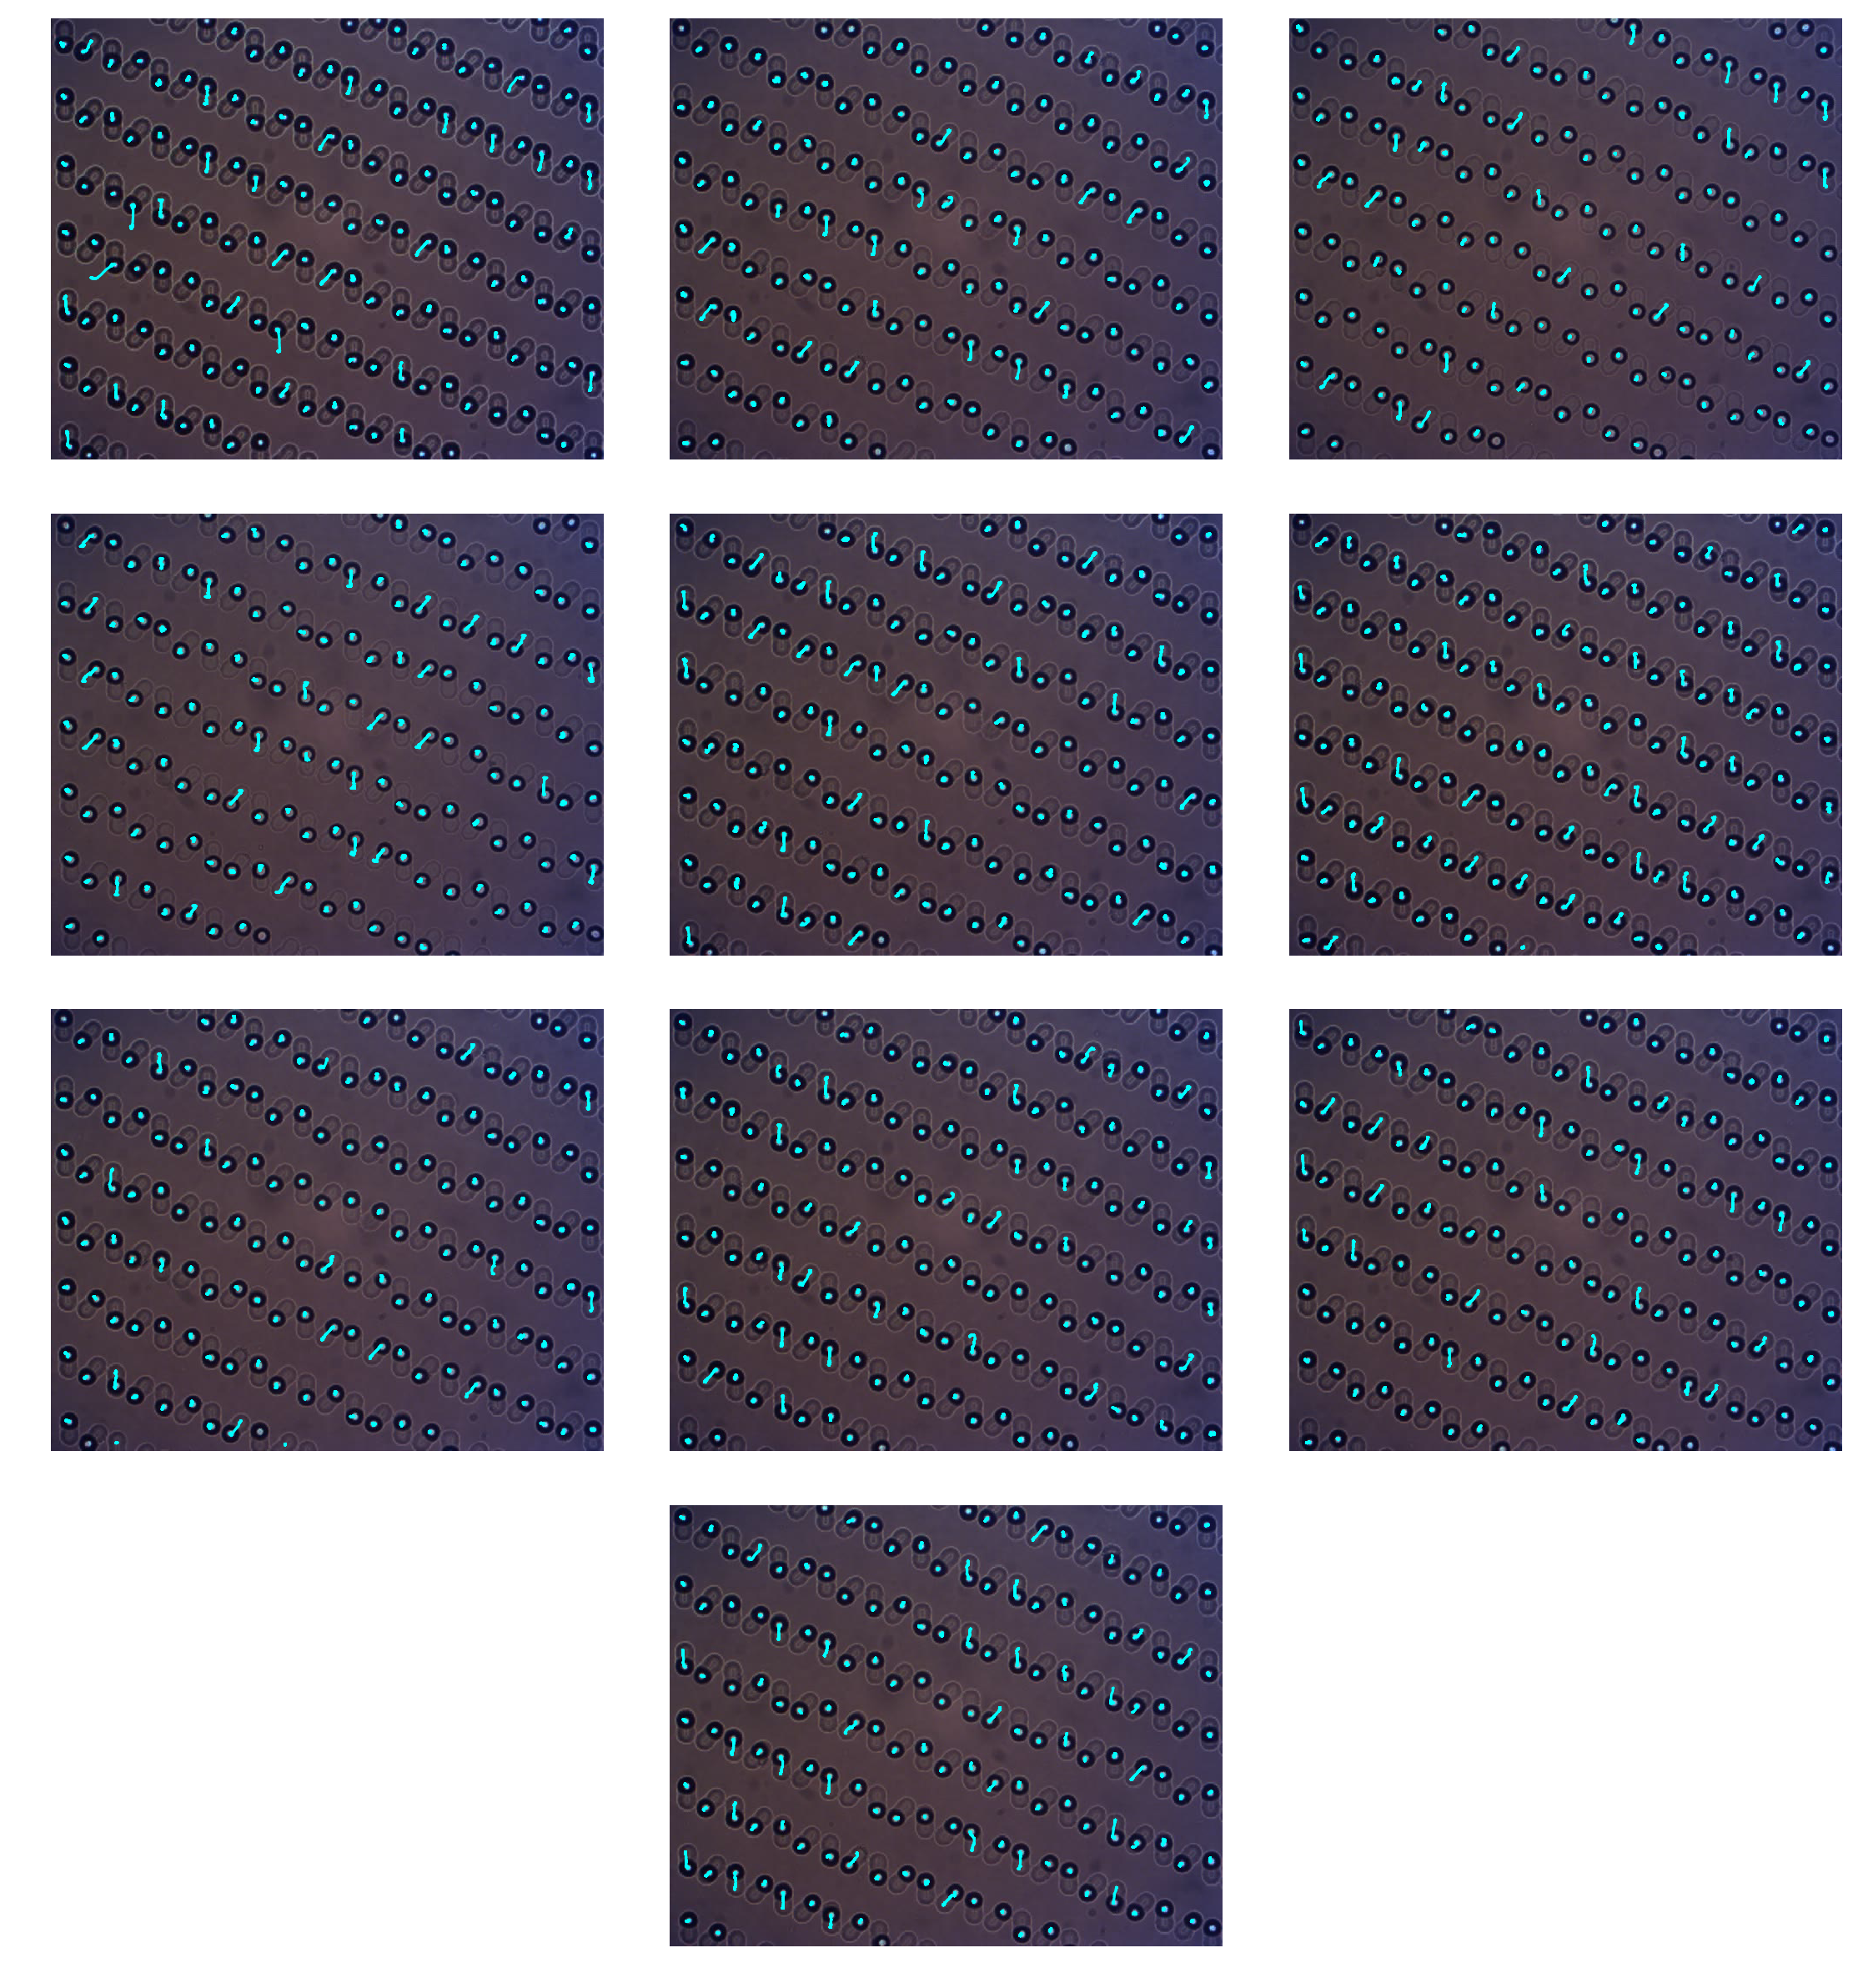

In [6]:
fig, ax = plt.subplots(4,3,figsize=(15,16))

ax.flatten()[-3].remove()
ax.flatten()[-1].remove()
ax = np.delete(ax.flatten(),slice(-3,None,2))

for file_no, filename in enumerate(filenames[0:]):

    trj = pd.read_csv(filename[:filename.find(".avi")]+"_tracking2.dat", index_col = [0,1], sep ="\t")
    trj = remove_stubs(trj,0.9)
    
    trj.to_csv(filename[:filename.find(".avi")]+"_trj.dat",sep = "\t")
    
    video = pm.open(filename)
    ax.flatten()[file_no].imshow(video[file_no])
    ax.flatten()[file_no].set_axis_off()

    for p,trj_p in trj.groupby("particle"):
        ax.flatten()[file_no].plot(trj_p.x, trj_p.y, color="cyan")
        
plt.tight_layout()

This parameter for removing stubs (short trajectories) shows good results, in which most of the particles are tracked consistently. 

## Add time information to trajectories

The LabVIEW recording program stores each frame's timestamp in a `.dat` file along with the video. 

In [7]:
for filename in filenames:
    
    name = filename[:filename.find(".avi")]

    trj = pd.read_csv(name+"_trj.dat", index_col = [0,1], sep ="\t")

    date_parser = lambda time : pd.to_datetime(
        float(time)+2*3600, unit="s", origin=pd.Timestamp('1904-01-01'))

    timestamps = pd.read_csv(name+'.dat',
                             sep = "\t", usecols = [0], names = "t", parse_dates = [0], date_parser = date_parser)

    trj["t"] = timestamps.loc[trj.index.get_level_values("frame")]["t"].values

    trj.to_csv(name+"_trj.dat",sep = "\t")

## Add the value of the field

In [1]:
import os
import sys
import glob
sys.path.insert(0, './')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm_notebook

idx = pd.IndexSlice

In [2]:
## Directory where the data is located
directory = "C:/Users/aortiza/Desktop/ShearedSquare/Theta45"

## Get a list of videos in that folder
theta = 45
filenames = [file for file in glob.glob(
    os.path.join(directory,('*.avi')))]
filenames = [f for f in filenames if not (f.find("O2")>0) and not (f.find("O1")>0)]

The following dataframe stores the details of the applied field. The most important of these is the starting time of the voltage ramp.

The filename field would be useful to know which start_time corresponds to which file, but it was not recorded properly. To work around this mistake, we will use the timestamps of the trajectories, which must be non-overlapping. 

In [3]:
date_parser = lambda time : pd.to_datetime(
    float(time)+2*3600, unit="s", origin=pd.Timestamp('1904-01-01'))

In [4]:
time_field_df = pd.read_csv(
    os.path.join(directory,"voltage_ramp.dat"), delimiter= "\t",parse_dates = [0], date_parser = date_parser,
    header = None, names = ["start_time","V0","Vf","total_time","filename"])
time_field_df.head()

start_time   V0   Vf  total_time  \
0 2019-06-04 15:32:26.218125820  0.0  8.0       600.0   
1 2019-06-04 16:15:18.058560848  0.0  8.0       600.0   
2 2019-06-04 16:38:14.478288174  0.0  8.0       600.0   
3 2019-06-04 17:10:35.497707367  0.0  8.0       600.0   
4 2019-06-04 17:37:04.618100643  0.0  8.0       600.0   

                       filename  
0  E5_M8_teta45_10um_2019_06_04  
1  E5_M8_teta45_10um_2019_06_04  
2  E5_M8_teta45_10um_2019_06_04  
3  E5_M8_teta45_10um_2019_06_04  
4  E5_M8_teta45_10um_2019_06_04

In [5]:
trj = pd.concat(
    [pd.read_csv(name[:name.find(".avi")]+"_trj.dat", sep = "\t", index_col = [0,1]) for name in tqdm_notebook(filenames)],
    keys = [os.path.split(name[:name.find(".avi")])[1] for name in filenames], names = ["filename"])

C:\Users\aortiza\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [6]:
trj.t = pd.to_datetime(trj.t)

In [7]:
names = trj.index.get_level_values("filename").unique()

In [8]:
def is_part(time_field, trj_file):
    dt = (trj_file.t-time_field.start_time).dt.total_seconds()
    return any(dt>0) & any(dt<0)

for name, trj_file in trj.groupby("filename"):
    where = time_field_df.apply(is_part, args = [trj_file], axis=1)
    time_field_df.loc[where[where].index,"filename"] = name

In [9]:
time_field_df.head()

start_time   V0   Vf  total_time  \
0 2019-06-04 15:32:26.218125820  0.0  8.0       600.0   
1 2019-06-04 16:15:18.058560848  0.0  8.0       600.0   
2 2019-06-04 16:38:14.478288174  0.0  8.0       600.0   
3 2019-06-04 17:10:35.497707367  0.0  8.0       600.0   
4 2019-06-04 17:37:04.618100643  0.0  8.0       600.0   

                                filename  
0  E5_M8_teta45_10um_2019_06_04_15_32_20  
1  E5_M8_teta45_10um_2019_06_04_16_15_15  
2  E5_M8_teta45_10um_2019_06_04_16_38_13  
3  E5_M8_teta45_10um_2019_06_04_17_10_34  
4  E5_M8_teta45_10um_2019_06_04_17_37_03

In [10]:
trj["field"] = np.NaN

for name, trj_file in tqdm_notebook(trj.groupby("filename")):
    field_params = time_field_df[time_field_df.filename==name]
    m = (field_params.Vf-field_params.V0)/field_params.total_time
    dt = trj_file.t-time_field_df[time_field_df.filename==name].start_time.values[0]
    trj.loc[idx[name,:,:],"field"] = dt.dt.total_seconds()*m.values[0]
    
trj.loc[trj["field"]<0,"field"] = 0

We will save the result to a single dataset, which contains field, time, and filename. Even though it is almost 3Gb, this dataset takes about 30s to read, which is manageable. 

In [11]:
trj.to_csv(os.path.join(directory,"trajectories.dat"), sep = "\t")

In [12]:
trj.head()

y           x  \
filename                              frame particle                           
E5_M8_teta45_10um_2019_06_04_15_32_20 0     0          12.782989  400.210952   
                                            1         336.474550  592.194478   
                                            2         337.851304  436.608769   
                                            3         338.967914  205.769489   
                                            4         339.904566  404.501803   

                                                             mass  \
filename                              frame particle                
E5_M8_teta45_10um_2019_06_04_15_32_20 0     0         3570.726231   
                                            1         3337.539218   
                                            2         4039.103584   
                                            3         3458.940704   
                                            4         4001.040412   

                                                                                 t  \
filename                              frame particle                                 
E5_M8_teta45_10um_2019_06_04_15_32_20 0     0        2019-06-04 15:32:20.119999886   
                                            1        2019-06-04 15:32:20.119999886   
                                            2        2019-06-04 15:32:20.119999886   
                                            3        2019-06-04 15:32:20.119999886   
                                            4        2019-06-04 15:32:20.119999886   

                                                      field  
filename                              frame particle         
E5_M8_teta45_10um_2019_06_04_15_32_20 0     0           0.0  
                                            1           0.0  
                                            2           0.0  
                                            3           0.0  
                                            4           0.0